## Using scripts to perform Intel Advisor roofline profiling on Devito

This notebook uses the prewritten scripts `run_advisor.py`, `roofline.py` and `advisor_to_json.py` to show how you can easily profile a Devito application using Intel Advisor 2020 and plot memory-bound/compute-bound roofline models depicting the current state of the application's performance. These scripts can be found in the `scripts/advisor` folder of the full Devito repository.

First, we are going to need a couple of imports to allow us to work with Devito and to run command line applications from inside this jupyter notebook. These will be needed for all three scripts.

In [1]:
import numpy as np
from devito import *
from IPython.display import Image
import sys
from subprocess import check_call

### Setting up the Advisor environment

Before running the following pieces of code, we must make sure that the Advisor environment is correctly activated on the machine you wish to use the scripts on. To do so, run the following command:

`source /opt/intel/advisor/advixe-vars.sh`

If your Advisor has not been installed in the `/opt/intel/advisor/advixe-vars.sh` directory, replace it with your chosen path.

### Collecting performance data with `run_advisor.py`

Before generating graphical models or have data to be exported, we need to collect the performance data of our interested program. The command line that we will use is `python3 ../../scripts/advisor/run_advisor.py --path ../../benchmarks/user/benchmark.py --exec-args "run -P acoustic -d 512 512 512 -so 4 --tn 50 --autotune off" --output ./profilings --name JupyterProfiling`.

* `--path` specifies the path of the Devito/python executable,
* `--exec-args` specifies the command line arguments that we want to pass to our executable,
* `--output` specifies the directory where we want to permanently save our profiling reports,
* `--name` specifies the name of the single profiling that will be effected.

The following is some small setup to allow us to use the in-python `check_call` function from the `subprocess` package to run command line applications from code (including some python autodetection from `sys`).

In [2]:
local_python = sys.executable
run_advisor = '../../scripts/advisor/run_advisor.py'

Now, set up all the command line options for the script and place the command all together.

In [3]:
test_file = '../../benchmarks/user/benchmark.py'
exec_args = 'run -P acoustic -d 128 128 128 -so 4 --tn 100 --autotune off'
profilings_directory = './profilings'
profiling_name = 'JupyterProfiling'

In [4]:
run_advisor_cmd = [local_python, run_advisor,
                   '--path', test_file,
                   '--exec-args', exec_args,
                   '--output', profilings_directory,
                   '--name', profiling_name
                  ]

Now, call the script on the command line to produce the profiling report in our chosen directory.

In [5]:
#NBVAL_SKIP

check_call(run_advisor_cmd)

0

The above call might take a few minutes depending on what machine you are running the code on, please have patience. After it is done, we have Intel Advisor data from which we can generate rooflines and export data.

### Generating a roofline model to display profiling data

Now that we have collected the data inside a profiling directory, we can use the `roofline.py` script to produce a pdf of the roofline data that has been collected in the previous run. There are two visualisation modes for the generated roofline:
* overview: displays a single point with the overall GFLOPS/s and arithmetic intensity of the program
* top-loops: displays all points within runtime within one order of magnitude compared to the top time consuming loop

First, we will produce an 'overview' roofline. The command line that we will use is `python3 ../../scripts/advisor/roofline.py --mode overview --name ./resources/OverviewRoof --project ./profilings/JupyterProfiling`.

* `--mode` specifies the mode as described (either `overview` or `top-loops`)
* `--name` specifies the name of the pdf file that will contain the roofline representation of the data
* `--project` specifies the directory where the profiling data is stored

In [6]:
roofline = '../../scripts/advisor/roofline.py'

In [7]:
mode = 'overview'
figure_name = './resources/OverviewRoof'
profiling_directory = './profilings/JupyterProfiling'

In [8]:
roofline_cmd = [local_python, roofline,
                '--mode', mode,
                '--name', figure_name,
                '--project', profiling_directory
               ]

After the command has been set up as a list, we can run it from python.

In [9]:
#NBVAL_SKIP

check_call(roofline_cmd)

0

Once this command has completed, we can now observe the gathered profiling data through a roofline model.

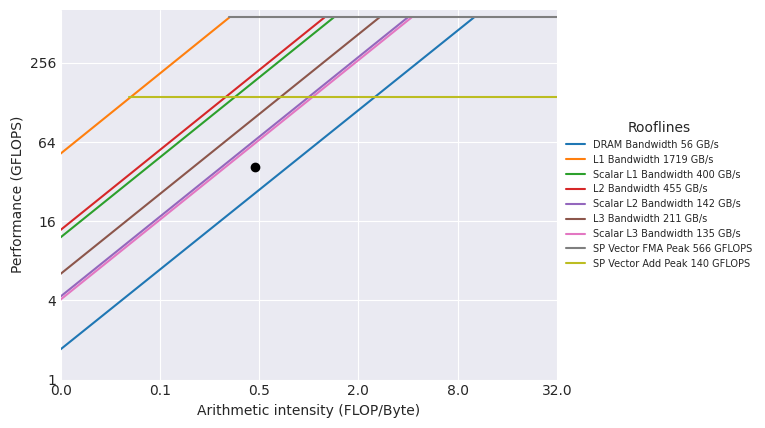

In [10]:
Image(filename='./resources/OverviewRoof.png')

Similarly, we can also produce a graph which displays the most time consuming loop alongside all other loops which have execution time within one order of magnitude from it. This is done by using `top-loops` mode.

As before, we need an initial setup of the command line to be able to run the script. Besides the mode and the name of the image which we change for convenience, everything else remains the same.

In [11]:
mode = 'top-loops'
figure_name = './resources/TopLoopsRoof'

roofline_cmd = [local_python, roofline,
                '--mode', mode,
                '--name', figure_name,
                '--project', profiling_directory
               ]

Now that the command line has been setup, let's run it to create this new image and display it.

In [12]:
#NBVAL_SKIP

check_call(roofline_cmd)

0

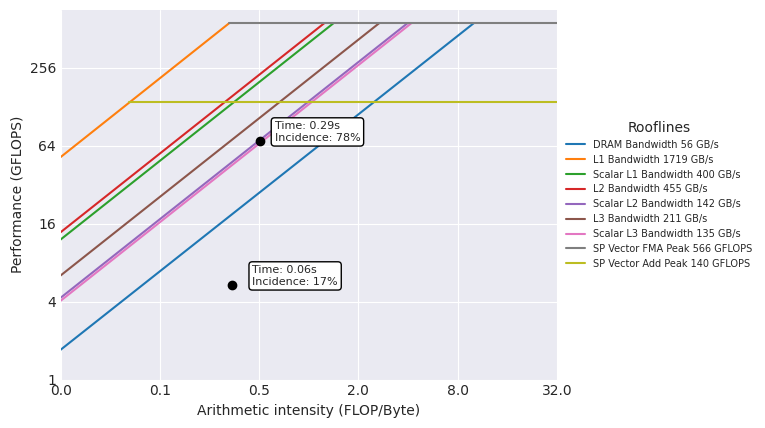

In [13]:
Image(filename='./resources/TopLoopsRoof.png')

As you can see from this roofline graph, the main point is different from the single point of the previous graph. Moreover, each point is labelled with 'Time' and 'Incidence' indicators. These represent the total execution time of each loop's main body and their percentage incidence on the total execution time of the main time loop.

### Exporting Advisor roofline data as JSON

For easy and flexible exporting, the `advisor_to_json.py` script allows you to pack all the information represented within the previously seen graphs inside a JSON file. The command line which is needed to export our project's data in JSON format is: `python3 ../../scripts/advisor/advisor_to_json.py --name ./resources/RoofsData --project ./profilings/JupyterProfiling`.

* `--name` specifies the name of the JSON file which will be generated
* `--project` specifies the Advisor folder which contains all the collected data about the application

As always, there is an initial setup of the command line which allows us to run the command from python.

In [14]:
advisor_to_json = '../../scripts/advisor/advisor_to_json.py'
json_name = './resources/RoofsData'
profiling_directory = './profilings/JupyterProfiling'

advisor_to_json_cmd = [local_python, advisor_to_json,
                       '--name', json_name,
                       '--project', profiling_directory
                      ]

Now that the command is ready, it can be run to generate our desired JSON file.

In [15]:
#NBVAL_SKIP

check_call(advisor_to_json_cmd)

0

We can now open the generated JSON file.

In [16]:
json_file = open('./resources/RoofsData.json', 'r')
json_file.read()

'{"roofs": {"memory": [[[0, 10.048214074440045], [0, 566.401163217]], [[0, 0.32941926554118744], [0, 566.401163217]], [[0, 1.4158476683664405], [0, 566.401163217]], [[0, 1.2443444952065132], [0, 566.401163217]], [[0, 3.9812243222283934], [0, 566.401163217]], [[0, 2.679794647632411], [0, 566.401163217]], [[0, 4.201657222191908], [0, 566.401163217]]], "compute": [[[0.32941926554118744, 32], [566.401163217, 566.401163217]], [[0.08142873349483178, 32], [140.00799041, 140.00799041]]]}, "overview": {"total_ai": 0.471487353924746, "total_gflops": 41.1003748608823}}'

Let's take a look at the generated JSON. Inside we can see that the file is subdivided into three sections: one to hold the points used to draw the rooflines (`roofs`), one to contain the single overview point (`overview`) and another one that contains information about the top loops as specified earlier in this tutorial (`top-loops`).

By default, `advisor_to_json.py` collects both overview and top-loops data, but the information to collect can be specified using a `--mode` flag analogous to the one used in `roofline.py`.

### Further flags and functionality

The last two scripts contain more flags that you can use to adjust data collection, displaying and exporting.

`roofline.py`:
* `--scale` specifies how much rooflines should be scaled down due to using fewer cores than available
* `--precision` specifies the arithmetic precision of the integral operators
* `--th` specifies the threshold percentage over which to display loops in top-loops mode

`advisor_to_json.py`:
* `--scale`, as previously
* `--precision`, as previously
* `--th`, as previously

If you want to learn more about what they do, add a `--help` flag to the script that you are executing.